# Pre-Processing
In the Preprocessing stage, I first split the dataset into training and testing sets to ensure that the models can be properly trained and evaluated on separate data. The training set is used to fit and optimize the supervised classification models, while the testing set is reserved for assessing their predictive performance.  

Next, I created preprocessing pipelines for both numeric and categorical features. The numeric transformer uses an `SimpleImputer` to fill in missing values based on the medians of the numeric variables, followed by a `StandardScaler` to normalize their ranges. The categorical transformer also uses an `SimpleImputer` with the most frequent category strategy to handle missing values and then applies a `OneHotEncoder` to convert categorical features into numerical format suitable for modeling. These transformations are combined within a `ColumnTransformer` to ensure that each feature type is processed appropriately and consistently, producing a clean and fully prepared dataset for model training.

### Import Python Packages & Dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.pipeline import Pipeline  as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.disable_max_rows()


# Import dataset that was created in the "5509_income_pre_modeling.ipynb" workbook
df = pd.read_csv('./df.csv')

# Define column types
categorical_columns = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
 ]
numeric_columns = [
    'age',
    'fnlwgt',
    'education-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
 ]

DataTransformerRegistry.enable('default')

### Train Test Split
- The dataset is now divided into a training set that will be used to build supervised classification models, and a testing set for evaluating their performance.

In [4]:
# Define the predictors
X = df[['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']]

# Define the target
y = df['income']

# Drop the target from the categorical_columns list
categorical_columns = [col for col in categorical_columns if col != 'income']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check shape of X_train, X_test, y_train, & y_test
print(f'X_train shape = {X_train.shape}    y_train shape = {y_train.shape}')
print(f'X_test shape =  {X_test.shape}     y_test shape =  {y_test.shape}')

X_train shape = (39050, 13)    y_train shape = (39050,)
X_test shape =  (9763, 13)     y_test shape =  (9763,)


### Preprocessing Transformers
- Next we build a preprocessing pipeline that prepares numeric and categorical data for modeling. Numeric features are imputed using their median values and standardized for consistent scaling, while categorical features are imputed with the most frequent category and one-hot encoded into binary variables. The `ColumnTransformer` then applies these transformations to their respective columns, producing a clean, model-ready dataset.
- To aid in modeling dummy columns will be added during imputing to indicate where data was missing for the `capital-gain`, `capital-loss`, `workclass`, `occupation`, and `native-country` columns.

In [ ]:
numeric_transformer = ImbPipeline([
    # ('imputer', IterativeImputer(initial_strategy='median', add_indicator=True)),
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

categorical_transformer = ImbPipeline([
    # ('imputer', IterativeImputer(initial_strategy='most_frequent', add_indicator=True)),
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='drop'
)

### Preprocessing - Conclusions/Discussions/Next Steps:
During preprocessing, the main challenge identified was ensuring that the imputation process accurately captured relationships among variables without introducing bias, especially given the number of missing values in both numeric and categorical features.  

With the data now standardized and encoded, the next step will be to apply supervised learning models to classify `income` levels and evaluate their performance on the testing set.

# Modeling
In the Modeling section, I first define several helper functions to streamline the evaluation process by generating learning curves, classification reports, confusion matrices, ROC curves, and feature selection summaries.  

Three supervised classification models are developed:
- a Logistic Regression model to estimate class probabilities using a sigmoid function,
- a Support Vector Classifier (SVC) to separate classes by finding the optimal decision boundary, and
- a Random Forest Classifier to aggregate multiple decision trees for improved accuracy and robustness.

Each model is trained using the preprocessed training data and evaluated on the test set to measure performance.  

Finally, ROC curves are plotted to compare all three classifiers and visually assess their ability to distinguish between `income` classes.

### Modeling Helper Functions
- These helper functions are used to evaluate model performance by creating:
  - Learning curve plots (`plot_learning_curve` function)
  - Classification tables (`create_classification_output` function)
  - Confusion matrices (`create_classification_output` function)
  - ROC curves (`make_roc_curves` function)
- There are also functions used to:
  - Identify dropped columns during feature selection (`show_selected_features` function)
  - Extract the best hyperparameters from cross-validation (`best_params_for` function)

In [6]:
# Function to check if a model has already been fit then load the model, otherwise fit the model
def fit_model(pipe, X_train, y_train, filename):
    if os.path.exists(filename):
        print(f"Loading saved model from {filename}")
        fitted_model = joblib.load(filename)
    else:
        print(f"Fitting model and saving to {filename}")
        fitted_model = pipe.fit(X_train, y_train)
        joblib.dump(fitted_model, filename)
    return fitted_model

# Function to plot the learning curve for a given model
def plot_learning_curve(estimator, X, y, clf_type):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X, y=y,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 5),  # fewer points = faster
        shuffle=True,
        random_state=42
    )
    train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, 'o-', label='Training')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve\n({clf_type})')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Function to output the learning curve, classification report, and confusion matrix for a given model
def create_classification_output(pipe, clf_type):
    # Plot learning curve
    print('\n' + '=' * 110)
    print(f'{clf_type} Learning Curve:')
    plot_learning_curve(pipe, X_train, y_train, clf_type=clf_type)

    # Print classification report
    print('\n' + '=' * 110)
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred, digits=4)
    acc = accuracy_score(y_test, y_pred)
    print(f'{clf_type} Report:\n{report}')
    print(f'Accuracy: {acc:.4f}')

    # Plot confusion matrix
    print('\n' + '=' * 110)
    print(f'{clf_type} Confusion Matrix:')
    # cls = pipe.named_steps['classifier'].classes_
    labels = ['<=50K', '>50K']
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Test Data Confusion Matrix\n({clf_type})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return acc

# Function to plot ROC curves and a AUC summary chart to compare models
def make_roc_curves(X_test, y_test, models):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})
    aucs, colors = {}, {}

    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        auc = roc_auc_score(y_test, y_score)
        aucs[name] = auc
        disp = RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax1, pos_label='>50K')
        colors[name] = disp.line_.get_color()

    # ROC Curves
    ax1.plot([0, 1], [0, 1], 'k--', label='Chance')
    ax1.set_title('ROC Curves')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False, fontsize=9)

    # AUC Sumamry Chart
    names, scores = zip(*sorted(aucs.items(), key=lambda kv: kv[1], reverse=True))
    bar_colors = [colors[n] for n in names]
    bars = ax2.bar(range(len(names)), scores, color=bar_colors)
    ax2.set_xticks(range(len(names)))
    ax2.set_xticklabels(names, rotation=90, ha='center')
    ax2.set_ylabel('AUC'); ax2.set_ylim(0.8, 1.0); ax2.set_title('AUC by Model Type')
    for rect, s in zip(bars, scores):
        ax2.text(rect.get_x() + rect.get_width()/2.0, rect.get_height() + 0.005, f'{s:.3f}',
                 ha='center', va='bottom', fontsize=9)

    fig.tight_layout(); fig.subplots_adjust(bottom=0.25)
    plt.show()

# Function to show which features are being dropped during feature selection
def show_selected_features(pipe, clf_type):
    preprocess = pipe.named_steps['preprocessor']
    selector = pipe.named_steps['selector']

    feature_names = preprocess.get_feature_names_out()
    kept_mask = selector.get_support()
    coef = getattr(selector.estimator_, 'coef_', None)
    l1_importance = np.abs(coef).ravel() if coef is not None else np.zeros_like(kept_mask, dtype=float)

    selector_df = (
        pd.DataFrame({
            'feature': feature_names,
            'kept': kept_mask,
            'l1_importance': l1_importance
        })
        .assign(status=lambda d: np.where(d.kept, 'kept', 'dropped'))
        .sort_values(['kept', 'l1_importance'], ascending=[False, False])
        .reset_index(drop=True)
    )

    print('=' * 110)
    print(f'{clf_type} Feature Selection:')
    print(f'\n{kept_mask.sum()} of the {kept_mask.size} features are used in modeling\n')
    print('Features dropped from model:')
    for feat in selector_df.loc[~selector_df['kept'], 'feature']:
        print(f'\t{feat}')

# Function to extract the best model hyperparameters from cross-validation
def best_params_for(results, name):
    mask = results['param_classifier'].astype(str).str.contains(name)
    row = results[mask].sort_values('rank_test_score').iloc[0].dropna()
    params = {k: row[k] for k in row.index if k.startswith('param_')}
    params = {k.replace('param_', ''): v for k, v in params.items()}
    return params

### Logistic Classifier
- A Logistic Classifier predicts the probability that an observation belongs to a particular class by modeling the relationship between input features and a binary outcome using a logistic (sigmoid) function.

Loading saved model from logistic_pipe.pkl

Logistic Classification Learning Curve:


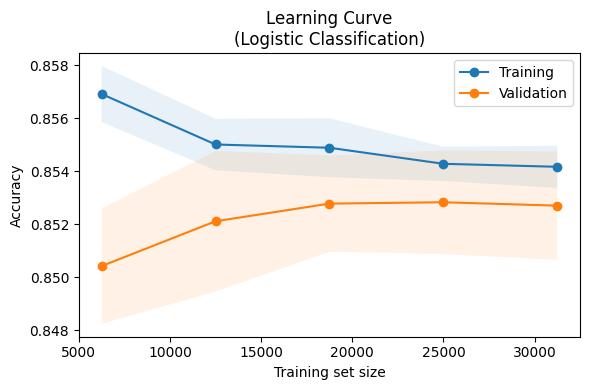


Logistic Classification Report:
              precision    recall  f1-score   support

       <=50K     0.8833    0.9375    0.9096      7426
        >50K     0.7533    0.6063    0.6719      2337

    accuracy                         0.8582      9763
   macro avg     0.8183    0.7719    0.7907      9763
weighted avg     0.8522    0.8582    0.8527      9763

Accuracy: 0.8582

Logistic Classification Confusion Matrix:


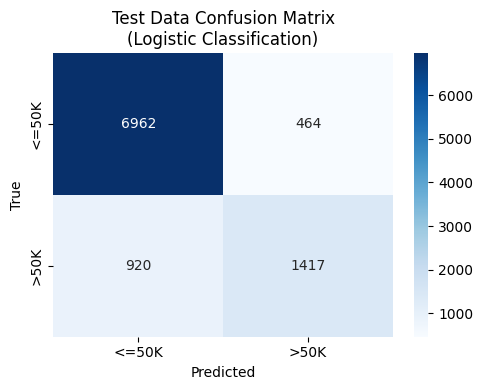

In [ ]:
# Create logistic classifier pipeline instance
logistic_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', LogisticRegression(max_iter=2000, n_jobs=-1))
])

# Fit model
logistic_pipe = fit_model(logistic_pipe, X_train, y_train, 'logistic_pipe.pkl')

# Create classification output
logistic_accuracy = create_classification_output(logistic_pipe, 'Logistic Classification')

> The logistic regression model achieved an overall accuracy of 85.8%, performing strongly in predicting individuals earning ≤50K with higher recall (93.8%) than those earning >50K (60.6%). The learning curve shows stable training and validation accuracy, indicating a well-generalized model with minimal overfitting.

### Support Vector Classifier
- A Support Vector Classifier (SVC) separates classes by finding the optimal hyperplane that maximizes the margin between them, making it effective for both linear and non-linear classification problems.

Fitting model and saving to svc_pipe.pkl

Support Vector Classifier Learning Curve:


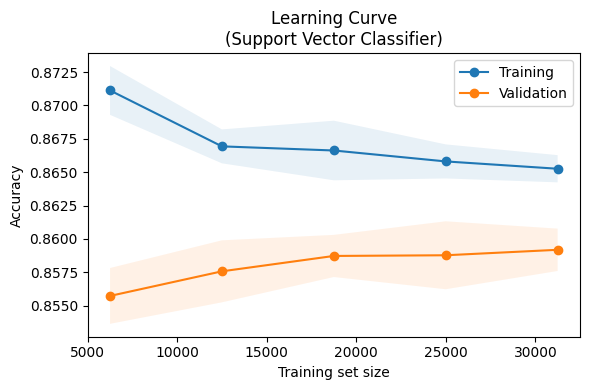


Support Vector Classifier Report:
              precision    recall  f1-score   support

       <=50K     0.8815    0.9500    0.9145      7426
        >50K     0.7892    0.5944    0.6781      2337

    accuracy                         0.8649      9763
   macro avg     0.8354    0.7722    0.7963      9763
weighted avg     0.8594    0.8649    0.8579      9763

Accuracy: 0.8649

Support Vector Classifier Confusion Matrix:


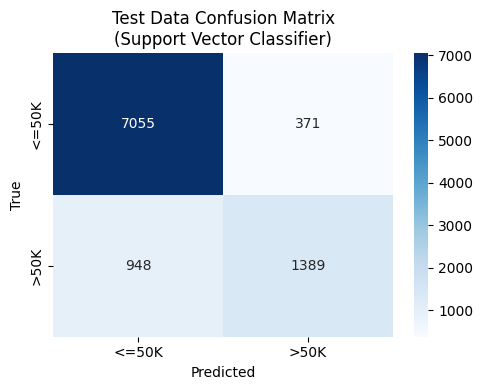

In [ ]:
# Create support vector classifier pipeline instance
svc_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', SVC(kernel='rbf', probability=True))
])

# Fit model
svc_pipe = fit_model(svc_pipe, X_train, y_train, 'svc_pipe.pkl')

# Create classification output
svc_accuracy = create_classification_output(svc_pipe, 'Support Vector Classifier')

> The support vector classifier achieved an overall accuracy of 86.5%, performing very well for predicting ≤50K incomes (95.0% recall) but less effectively for >50K incomes (59.4% recall). The learning curve shows consistent training and validation accuracy, suggesting good generalization with minimal overfitting.

### Random Forest Classifier
- A Random Forest Classifier builds an ensemble of decision trees on random subsets of the data and averages their predictions to improve accuracy and reduce overfitting.

Loading saved model from rf_pipe.pkl

Random Forest Classifier Learning Curve:


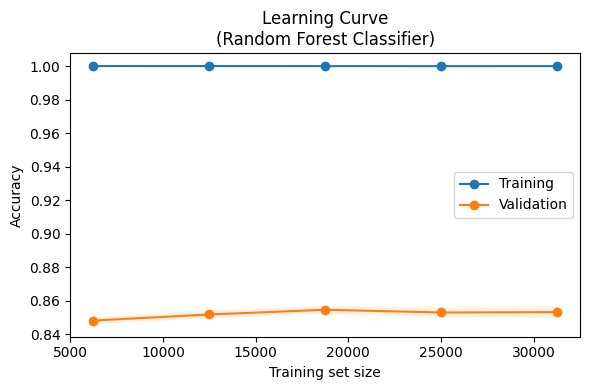


Random Forest Classifier Report:
              precision    recall  f1-score   support

       <=50K     0.8844    0.9286    0.9060      7426
        >50K     0.7304    0.6145    0.6674      2337

    accuracy                         0.8534      9763
   macro avg     0.8074    0.7715    0.7867      9763
weighted avg     0.8476    0.8534    0.8489      9763

Accuracy: 0.8534

Random Forest Classifier Confusion Matrix:


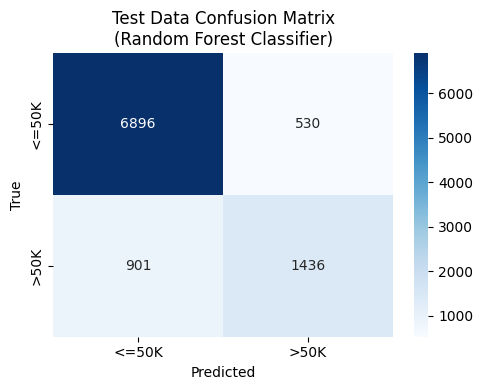

In [ ]:
# Create random forest classifier pipeline instance
rf_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Fit model
rf_pipe = fit_model(rf_pipe, X_train, y_train, 'rf_pipe.pkl')

# Create classification output
rf_accuracy = create_classification_output(rf_pipe, 'Random Forest Classifier')

> The random forest classifier achieved an overall accuracy of 85.3%, showing strong performance for predicting ≤50K incomes (92.9% recall) but weaker performance for >50K (61.5% recall). The learning curve indicates near-perfect training accuracy and a noticeable gap with validation accuracy, **suggesting some degree of overfitting**.

### ROC Curves - Base Classifier Models
- An ROC curve (Receiver Operating Characteristic curve) shows how well each classifier distinguishes between the positive and negative classes across different threshold values. It plots the True Positive Rate (sensitivity) against the False Positive Rate (1 - specificity), allowing you to visualize the trade-off between correctly identifying positives and incorrectly classifying negatives. When the logistic, support vector, and random forest classifiers are displayed on the same ROC curve, the one with a line closer to the top-left corner demonstrates better overall performance and a higher ability to separate the two classes.

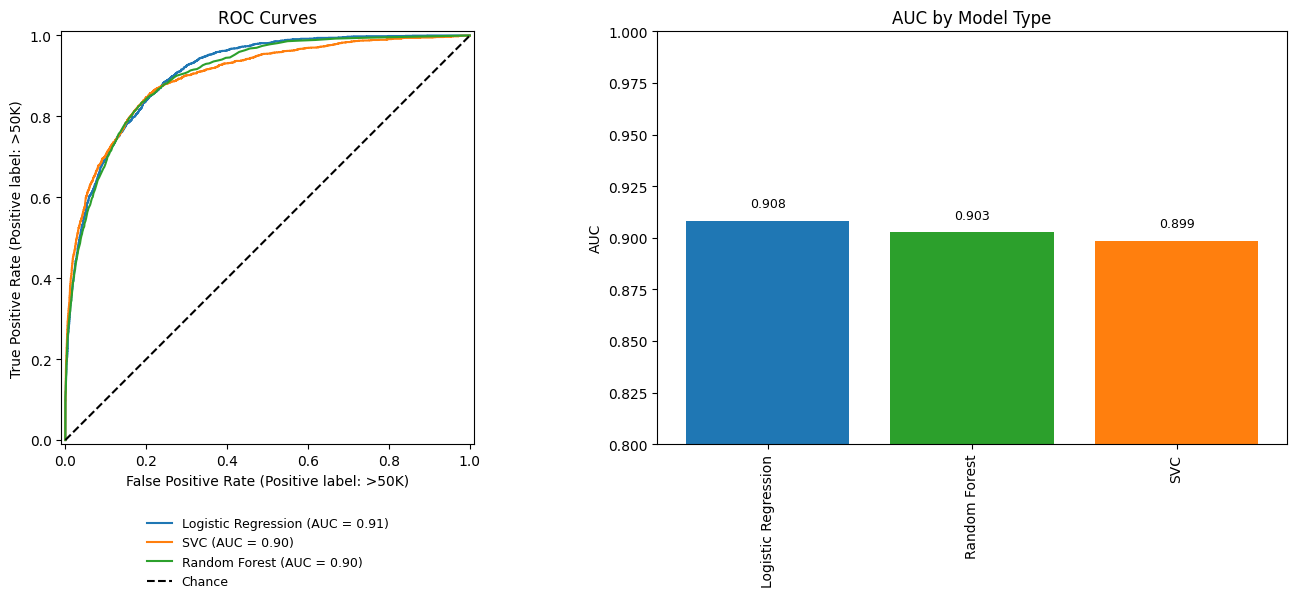

In [10]:
base_classifier_models = {
    'Logistic Regression':  logistic_pipe,
    'SVC':                  svc_pipe,
    'Random Forest':        rf_pipe,
}
make_roc_curves(X_test, y_test, base_classifier_models)

> All three models performed similarly well, with Logistic Regression achieving the highest AUC of 0.908, followed closely by Random Forest (0.903) and SVC (0.899). These results indicate that each model has a strong ability to distinguish between income classes, with only minor differences in overall predictive performance.

### Modeling - Conclusions/Discussions/Next Steps:
The modeling results showed that all three classifiers performed well, with Logistic Regression achieving the highest AUC (0.908) and accuracy (85.9%), followed closely by SVC and Random Forest. However, each model consistently performed better at predicting ≤50K incomes than >50K, suggesting class imbalance or overlapping feature distributions could limit precision for higher-income predictions.  

The next step, Feature Selection, will focus on identifying the most influential variables to simplify the models, improve computational efficiency, and reduce potential overfitting.

# Feature Selection
This is the process of identifying and keeping only the most relevant input variables that contribute significantly to a model’s predictions. In supervised classification, this helps improve model performance, reduce overfitting, and make the model more efficient by removing redundant or irrelevant features.

### Logistic Classifier (with feature selection)
- Now we train a logistic regression pipeline that preprocesses the data, performs feature selection using an L1-regularized logistic model to drop less important features, and then fits a logistic regression classifier to the preprocessed and feature selected dataset.

In [ ]:
# Create logistic classifier pipeline instance with feature selection
logistic_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=200))),
    ('classifier', LogisticRegression(max_iter=2000, n_jobs=-1))
])

# Fit model
logistic_fs_pipe = fit_model(logistic_fs_pipe, X_train, y_train, 'logistic_fs_pipe.pkl')

# Show the dropped features
show_selected_features(logistic_fs_pipe, 'Logistic Classification (with feature selection)')

Fitting model and saving to logistic_fs_pipe.pkl
Logistic Classification (with feature selection) Feature Selection:

79 of the 97 features are used in modeling

Features dropped from model:
	cat__workclass_Never-worked
	cat__workclass_Private
	cat__occupation_Armed-Forces
	cat__occupation_Craft-repair
	cat__relationship_Unmarried
	cat__race_Other
	cat__race_White
	cat__native-country_Ecuador
	cat__native-country_El-Salvador
	cat__native-country_Guatemala
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Honduras
	cat__native-country_Jamaica
	cat__native-country_Japan
	cat__native-country_Nicaragua
	cat__native-country_Outlying-US(Guam-USVI-etc)
	cat__missingindicator_workclass_True



Logistic Classification (with feature selection) Learning Curve:


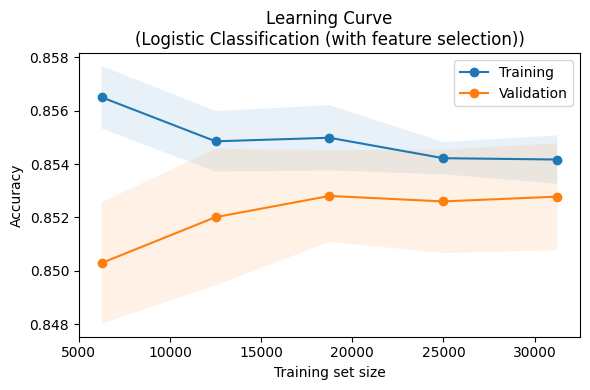


Logistic Classification (with feature selection) Report:
              precision    recall  f1-score   support

       <=50K     0.8834    0.9372    0.9095      7426
        >50K     0.7527    0.6068    0.6719      2337

    accuracy                         0.8581      9763
   macro avg     0.8180    0.7720    0.7907      9763
weighted avg     0.8521    0.8581    0.8526      9763

Accuracy: 0.8581

Logistic Classification (with feature selection) Confusion Matrix:


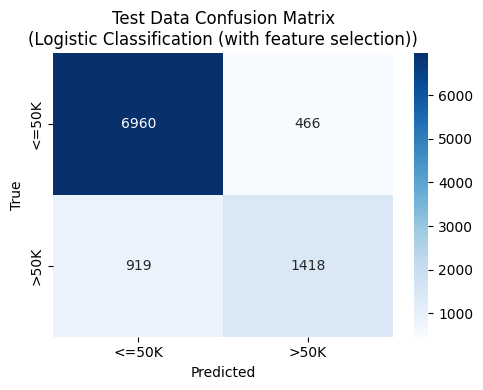

In [12]:
# Create classification output
logistic_fs_accuracy = create_classification_output(logistic_fs_pipe, 'Logistic Classification (with feature selection)')

> After applying feature selection, the logistic regression model achieved an accuracy of 85.8%, maintaining similar performance to the base model while using fewer features. The model continued to predict ≤50K incomes with high recall (93.7%) but showed lower recall (60.7%) for >50K, indicating it generalizes well but may still under-identify higher-income individuals.

### Support Vector Classifier (with feature selection)
- This code builds and trains a support vector classifier pipeline that preprocesses the data, uses an L1-regularized linear SVC to select the most important features, and then fits an RBF-kernel SVC for final classification..

In [ ]:
# Create support vector classifier pipeline instance
svc_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(LinearSVC(penalty="l1", dual=False, C=0.25, tol=1e-3, max_iter=50000))),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

# Fit model
svc_fs_pipe = fit_model(svc_fs_pipe, X_train, y_train, 'svc_fs_pipe.pkl')

# Show the dropped features
show_selected_features(svc_fs_pipe, 'Support Vector Classifier (with feature selection)')

Fitting model and saving to svc_fs_pipe.pkl
Support Vector Classifier (with feature selection) Feature Selection:

83 of the 97 features are used in modeling

Features dropped from model:
	cat__workclass_Never-worked
	cat__workclass_Private
	cat__occupation_Armed-Forces
	cat__relationship_Not-in-family
	cat__native-country_Cuba
	cat__native-country_Ecuador
	cat__native-country_El-Salvador
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Honduras
	cat__native-country_Jamaica
	cat__native-country_Japan
	cat__native-country_Nicaragua
	cat__native-country_Outlying-US(Guam-USVI-etc)



Support Vector Classifier (with feature selection) Learning Curve:


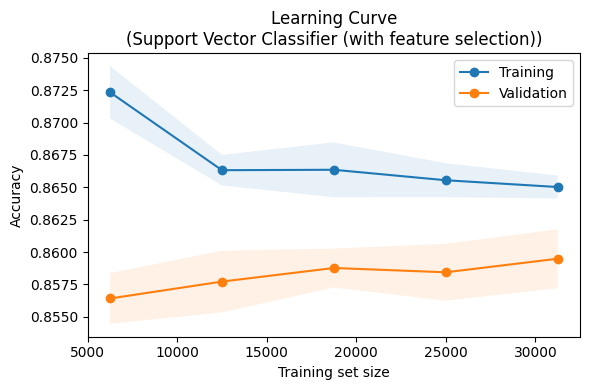


Support Vector Classifier (with feature selection) Report:
              precision    recall  f1-score   support

       <=50K     0.8803    0.9506    0.9141      7426
        >50K     0.7896    0.5892    0.6748      2337

    accuracy                         0.8641      9763
   macro avg     0.8349    0.7699    0.7945      9763
weighted avg     0.8586    0.8641    0.8568      9763

Accuracy: 0.8641

Support Vector Classifier (with feature selection) Confusion Matrix:


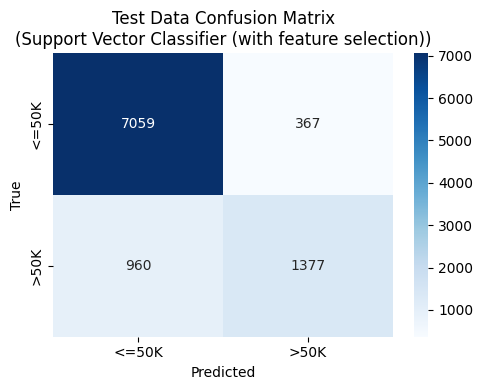

In [14]:
# Create classification output
svc_fs_accuracy = create_classification_output(svc_fs_pipe, 'Support Vector Classifier (with feature selection)')

> With feature selection applied, the support vector classifier achieved an accuracy of 86.4%, maintaining strong generalization and consistent performance with the base model. It performed very well for predicting ≤50K incomes (95.0% recall) but continued to show lower recall (58.9%) for >50K, indicating slightly better precision but limited improvement in identifying higher-income individuals.

### Random Forest Classifier (with feature selection)
- This code creates and trains a random forest pipeline that preprocesses the data, selects important features based on feature importance scores from an initial random forest, and then fits a final random forest classifier using those selected features.

In [ ]:
# Create random forest classifier pipeline instance
rf_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

# Fit model
rf_fs_pipe = fit_model(rf_fs_pipe, X_train, y_train, 'rf_fs_pipe.pkl')

# Show the dropped features
show_selected_features(rf_fs_pipe, 'Random Forest Classifier (with feature selection)')

Fitting model and saving to rf_fs_pipe.pkl
Random Forest Classifier (with feature selection) Feature Selection:

12 of the 97 features are used in modeling

Features dropped from model:
	num__missingindicator_capital-loss
	cat__workclass_Federal-gov
	cat__workclass_Local-gov
	cat__workclass_Never-worked
	cat__workclass_Private
	cat__workclass_Self-emp-inc
	cat__workclass_Self-emp-not-inc
	cat__workclass_State-gov
	cat__workclass_Without-pay
	cat__marital-status_Divorced
	cat__marital-status_Married-AF-spouse
	cat__marital-status_Married-spouse-absent
	cat__marital-status_Separated
	cat__marital-status_Widowed
	cat__occupation_Adm-clerical
	cat__occupation_Armed-Forces
	cat__occupation_Craft-repair
	cat__occupation_Farming-fishing
	cat__occupation_Handlers-cleaners
	cat__occupation_Machine-op-inspct
	cat__occupation_Other-service
	cat__occupation_Priv-house-serv
	cat__occupation_Protective-serv
	cat__occupation_Sales
	cat__occupation_Tech-support
	cat__occupation_Transport-moving
	cat__


Random Forest Classifier (with feature selection) Learning Curve:


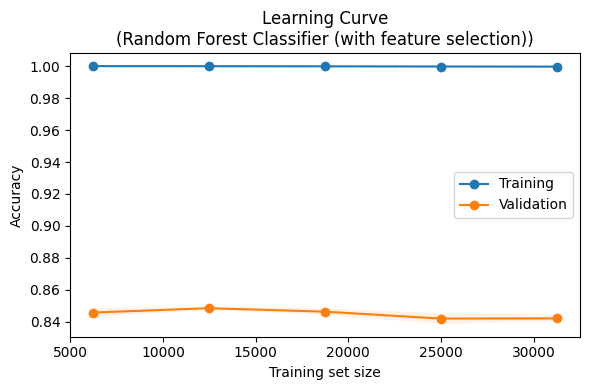


Random Forest Classifier (with feature selection) Report:
              precision    recall  f1-score   support

       <=50K     0.8815    0.9179    0.8993      7426
        >50K     0.6997    0.6080    0.6506      2337

    accuracy                         0.8437      9763
   macro avg     0.7906    0.7630    0.7750      9763
weighted avg     0.8380    0.8437    0.8398      9763

Accuracy: 0.8437

Random Forest Classifier (with feature selection) Confusion Matrix:


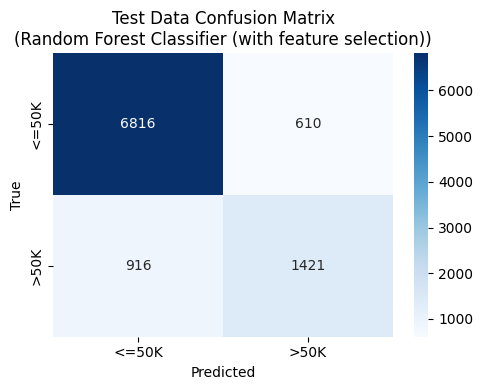

In [16]:
# Create classification output
rf_fs_accuracy = create_classification_output(rf_fs_pipe, 'Random Forest Classifier (with feature selection)')

> After applying feature selection, the random forest classifier achieved an accuracy of 84.4%, performing well on ≤50K incomes (91.9% recall) but less effectively on >50K (60.6% recall). The learning curve shows near-perfect training accuracy and lower validation accuracy, indicating persistent overfitting despite feature reduction.

### ROC Curves - Base vs. Feature Selected Models
- Comparing the base classifiers to the classifiers that have had feature selection applied.

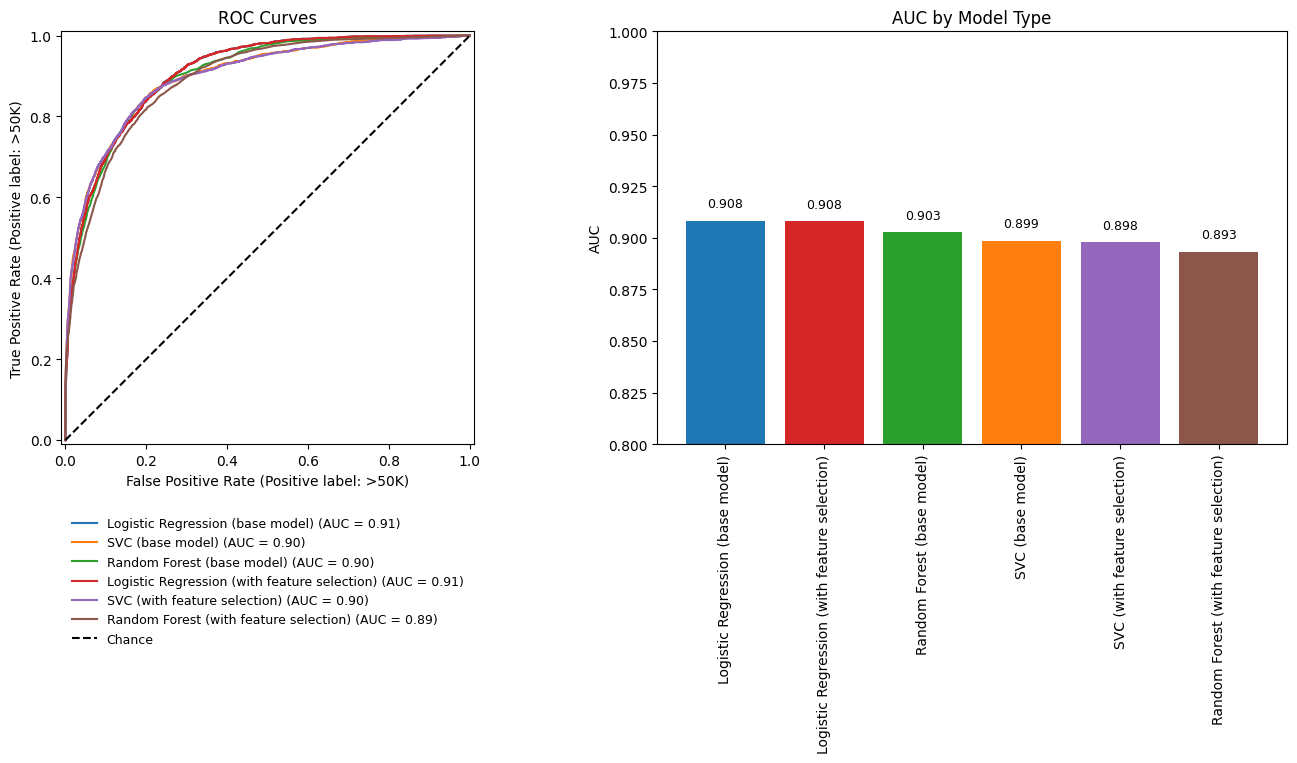

In [17]:
base_and_feature_selection_models = {
    'Logistic Regression (base model)':             logistic_pipe,
    'SVC (base model)':                             svc_pipe,
    'Random Forest (base model)':                   rf_pipe,
    'Logistic Regression (with feature selection)': logistic_fs_pipe,
    'SVC (with feature selection)':                 svc_fs_pipe,
    'Random Forest (with feature selection)':       rf_fs_pipe,
}

make_roc_curves(X_test, y_test, base_and_feature_selection_models)

> The ROC AUC results show that feature selection had minimal impact on overall model performance, with all models achieving similar AUC scores between 0.89 and 0.91. Logistic Regression maintained the highest AUC at 0.91 both before and after feature selection, indicating strong and consistent classification performance across all configurations.  
> 
> The SVC and Random Forest models with feature selection performed slightly worse because the feature selection process likely removed variables that, while individually weak, collectively contributed useful information to the models’ predictive power. Random Forests, in particular, are robust to irrelevant features and can internally handle feature importance, so external selection can actually reduce their effectiveness. Similarly, the SVC with a non-linear RBF kernel captures complex interactions between features, and removing some of them can disrupt those relationships, leading to a small drop in performance. In short, the feature selection simplified the models too much, slightly reducing their ability to capture subtle patterns in the data.

### Feature Selection - Conclusions/Discussions/Next Steps:
The feature selection results showed that reducing the number of features had little impact on overall model performance, with all models maintaining similar AUC scores between 0.89 and 0.91. Logistic Regression remained the strongest performer, while the SVC and Random Forest models showed slight declines, likely because the feature selection process removed variables that contributed subtle but meaningful information.  

The next step, Hyperparameter Tuning, will focus on optimizing each model’s parameters using cross-validation to improve predictive accuracy and further refine model performance.

# Hyperparameter Tuning
- This is the process of finding the best combination of model settings (such as regularization strength or tree depth) that optimize performance on unseen data.
- Using 5-fold cross-validation, the training data is split into five parts—four folds are used to train the model and one is used to validate it, repeating this process five times so each fold serves as validation once.
- The average performance across all folds helps identify the hyperparameters that generalize best to new data.

### Cross Validation
- This code performs hyperparameter tuning using GridSearchCV with 5-fold stratified cross-validation to find the best model configurations for logistic regression, SVC, and random forest classifiers—both with and without feature selection. It systematically tests combinations of hyperparameters (like C, max_depth, and selection thresholds) to identify the setup that achieves the highest accuracy across the folds.

In [ ]:
# Define a default pipeline to be used for cross-validation
pipeline = SkPipeline([
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'),   # default; swapped per grid
    ('classifier', LogisticRegression())
])

# Logistic Regression (with no feature selection)
logistic_without_feature_selection = {
    'classifier': [LogisticRegression(max_iter=2000, n_jobs=-1)],
    'classifier__C': [0.01, 0.1, 1, 10],
    'selector': ['passthrough']  # no selector__* keys here
}

# Logistic Regression (with feature selection)
logistic_with_feature_selection = {
    'classifier': [LogisticRegression(max_iter=2000, n_jobs=-1)],
    'classifier__C': [0.01, 0.1, 1, 10],
    'selector': [SelectFromModel(
        LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000)
    )],
    'selector__threshold': ['median', '1.5*mean', None]
}

# Support Vector Classifier (with no feature selection)
svc_without_feature_selection = {
    'classifier': [SVC(probability=True)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
    'selector': ['passthrough']
}

# Support Vector Classifier (with feature selection)
svc_with_feature_selection = {
    'classifier': [SVC(probability=True)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
    'selector': [SelectFromModel(
        LinearSVC(penalty='l1', dual=False, max_iter=50000, tol=1e-3)
    )],
    'selector__threshold': ['median', None]
}

# Random Forest Classifier (with no feature selection)
rf_without_feature_selection = {
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [1, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5],
    'selector': ['passthrough']
}

# Random Forest Classifier (with feature selection)
rf_with_feature_selection = {
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [1, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5],
    'selector': [SelectFromModel(RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ))],
    'selector__threshold': ['median', None]
}

# Define the parameter grid used for cross-validation
param_grid = [
    logistic_without_feature_selection, logistic_with_feature_selection,
    svc_without_feature_selection,      svc_with_feature_selection,
    rf_without_feature_selection,       rf_with_feature_selection
]

# Create a grid search instance
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Fit the grid search model to the training data
gs = fit_model(gs, X_train, y_train, 'gs.pkl')

# Display a dataframe of the cross-validation results
cv_results = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')
cv_results

Fitting model and saving to gs.pkl
Fitting 5 folds for each of 55 candidates, totalling 275 fits


/home/ryan-bulger/.local/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_selector,param_selector__threshold,param_classifier__max_depth,param_classifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,527.306201,3.687384,10.910888,0.738994,SVC(probability=True),1.50,passthrough,NaN,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.858003,0.863636,0.857106,0.860948,0.862100,0.860359,0.002460,1
25,889.655768,9.869849,5.457859,0.933831,SVC(probability=True),1.50,SelectFromModel(estimator=LinearSVC(dual=False...,None,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.856978,0.863636,0.856594,0.860948,0.861972,0.860026,0.002783,2
19,535.888132,9.882980,10.599043,0.488336,SVC(probability=True),2.00,passthrough,NaN,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.856466,0.864149,0.856594,0.860563,0.861972,0.859949,0.003016,3
27,764.654324,15.786031,3.464994,0.321814,SVC(probability=True),2.00,SelectFromModel(estimator=LinearSVC(dual=False...,None,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.856722,0.864020,0.856722,0.860691,0.861588,0.859949,0.002851,3
17,522.755296,4.411161,10.945938,0.445283,SVC(probability=True),1.00,passthrough,NaN,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.858131,0.860819,0.856594,0.859923,0.860435,0.859181,0.001588,5
23,516.248977,20.573999,10.813251,0.415617,SVC(probability=True),1.00,SelectFromModel(estimator=LinearSVC(dual=False...,None,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.858131,0.860563,0.856466,0.859795,0.860691,0.859129,0.001614,6
21,509.965553,9.150183,10.925707,0.678139,SVC(probability=True),0.50,SelectFromModel(estimator=LinearSVC(dual=False...,None,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.858003,0.859411,0.855186,0.860435,0.859539,0.858515,0.001838,7
16,519.653432,8.221800,11.896279,0.272803,SVC(probability=True),0.50,passthrough,NaN,NaN,NaN,"{'classifier': SVC(probability=True), 'classif...",0.858643,0.859539,0.855186,0.859795,0.859283,0.858489,0.001696,8
51,27.821921,0.728133,1.134618,0.174309,"RandomForestClassifier(n_jobs=-1, random_state...",NaN,SelectFromModel(estimator=RandomForestClassifi...,median,10.0,3.0,{'classifier': RandomForestClassifier(n_jobs=-...,0.855442,0.858003,0.851857,0.858387,0.857362,0.856210,0.002401,9
49,26.956149,0.572241,1.148823,0.141332,"RandomForestClassifier(n_jobs=-1, random_state...",NaN,SelectFromModel(estimator=RandomForestClassifi...,median,10.0,1.0,{'classifier': RandomForestClassifier(n_jobs=-...,0.854545,0.856978,0.851088,0.858899,0.856594,0.855621,0.002655,10


### Best Cross-Validated Model
- This is the best model and associated hyperparameters that achieve the highest value of accuracy of all models tested during cross-validation 

In [19]:
# Display the best cross-validated model hyperparameters
print('Best cross-validated model & hyperparameters:')
for k,v in gs.best_params_.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')
print(f'Best cross-validated accuracy for the above model = {gs.best_score_:.4f}')

Best cross-validated model & hyperparameters:
	classifier:	SVC(probability=True)
	classifier__C:	1.5
	selector:	None
Best cross-validated accuracy for the above model = 0.8604


> After cross-validation the best model is a **support vector classifier with no feature selection applied and a C-value=`1.5`**.

### Best Cross-Validated Hyperparameters for Each Classifier
- This displays the best hyperparameters that were found during cross-validation for each model

In [20]:
# Get the best GridSearchCV parameters for LogisticRegression
logistic_best_cv_params = best_params_for(cv_results, 'LogisticRegression')
print('Best cross-validated hyperparameters for Logistic Classifier:')
for k,v in logistic_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

Best cross-validated hyperparameters for Logistic Classifier:
	classifier:	LogisticRegression(max_iter=2000, n_jobs=-1)
	classifier__C:	10.0
	selector:	None


In [21]:
# Get the best GridSearchCV parameters for SVC
svc_best_cv_params = best_params_for(cv_results, 'SVC')
print('Best cross-validated hyperparameters for Support Vector Classifier:')
for k,v in svc_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

Best cross-validated hyperparameters for Support Vector Classifier:
	classifier:	SVC(probability=True)
	classifier__C:	1.5
	selector:	None


In [22]:
# Get the best GridSearchCV parameters for RandomForestClassifier
rf_best_cv_params = best_params_for(cv_results, 'RandomForestClass')
print('Best cross-validated hyperparameters for Random Forest Classifier:')
for k,v in rf_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

Best cross-validated hyperparameters for Random Forest Classifier:
	classifier:	RandomForestClassifier(n_jobs=-1, random_state=42)
	selector:	SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                                 random_state=42))
	selector__threshold:	median
	classifier__max_depth:	10.0
	classifier__min_samples_leaf:	3.0


> The best models, as determined by cross validation, for the Logistic Classifier and Support Vector Classifier **do not use feature selection** (as indicated by "selector:None" above); whereas the best Random Forest Classifier **does use feature selection**.

### Logistic Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Logistic Classifier (i.e. `logistic_best_cv_params`)

Fitting model and saving to logistic_tuned_pipe.pkl

Logistic Classification (hyperparameter tuned) Learning Curve:


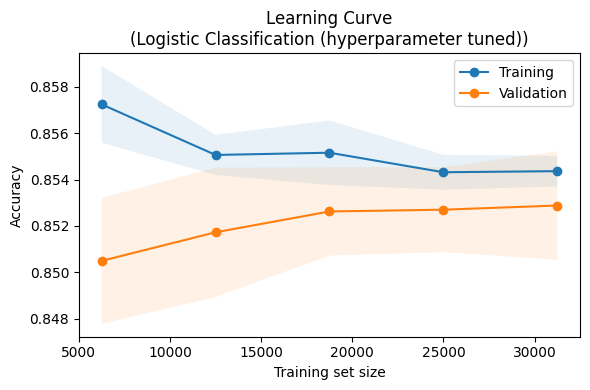


Logistic Classification (hyperparameter tuned) Report:
              precision    recall  f1-score   support

       <=50K     0.8833    0.9375    0.9096      7426
        >50K     0.7533    0.6063    0.6719      2337

    accuracy                         0.8582      9763
   macro avg     0.8183    0.7719    0.7907      9763
weighted avg     0.8522    0.8582    0.8527      9763

Accuracy: 0.8582

Logistic Classification (hyperparameter tuned) Confusion Matrix:


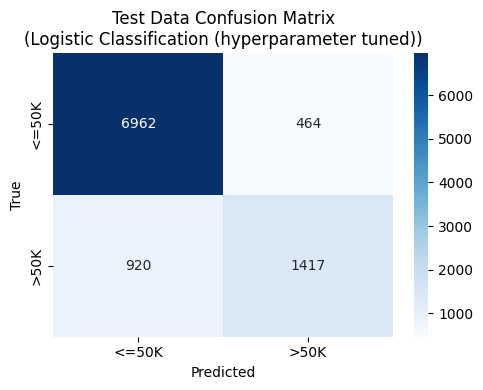

In [ ]:
# Build pipeline with the best LogisticRegression hyperparameters
logistic_tuned_pipe = SkPipeline([
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', LogisticRegression(max_iter=2000, n_jobs=-1))
]).set_params(**{k: v for k, v in logistic_best_cv_params.items() if k != 'classifier'})

# Fit model
logistic_tuned_pipe = fit_model(logistic_tuned_pipe, X_train, y_train, 'logistic_tuned_pipe.pkl')

# Create classification output
logistic_tuned_accuracy = create_classification_output(logistic_tuned_pipe, 'Logistic Classification (hyperparameter tuned)')

> After hyperparameter tuning, the logistic regression model achieved an accuracy of 85.9%, showing balanced training and validation performance with minimal overfitting. The optimized parameters maintained strong results for predicting ≤50K incomes (93.8% recall) but continued to show lower recall (60.6%) for >50K, indicating consistent performance with slightly improved model stability.

### Support Vector Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Support Vector Classifier (i.e. `svc_best_cv_params`)

Fitting model and saving to svc_tuned_pipe.pkl

Support Vector Classifier (hyperparameter tuned) Learning Curve:


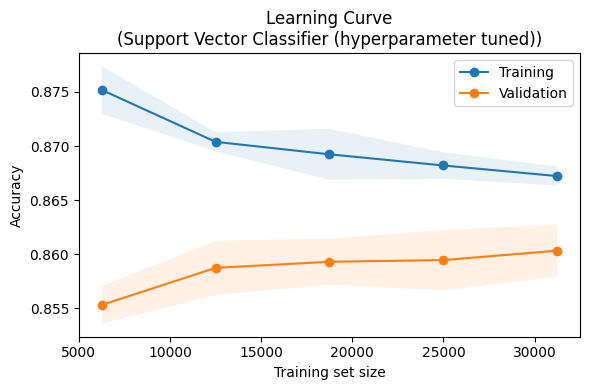


Support Vector Classifier (hyperparameter tuned) Report:
              precision    recall  f1-score   support

       <=50K     0.8827    0.9487    0.9145      7426
        >50K     0.7862    0.5995    0.6803      2337

    accuracy                         0.8651      9763
   macro avg     0.8345    0.7741    0.7974      9763
weighted avg     0.8596    0.8651    0.8584      9763

Accuracy: 0.8651

Support Vector Classifier (hyperparameter tuned) Confusion Matrix:


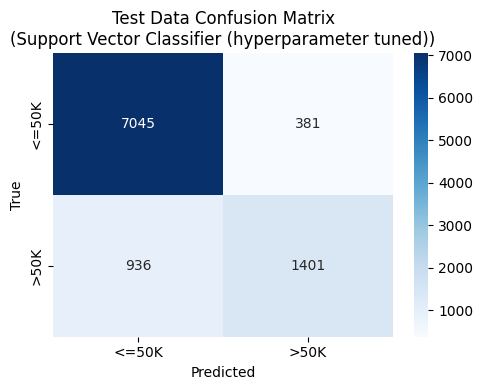

In [ ]:
# Build pipeline with the best SVC hyperparameters
svc_tuned_pipe = SkPipeline([
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', SVC(kernel='rbf', C=2.0, probability=True))
]).set_params(**{k: v for k, v in svc_best_cv_params.items() if k != 'classifier'})

# Fit model
svc_tuned_pipe = fit_model(svc_tuned_pipe, X_train, y_train, 'svc_tuned_pipe.pkl')

# Create classification output
svc_tuned_accuracy = create_classification_output(svc_tuned_pipe, 'Support Vector Classifier (hyperparameter tuned)')

> After hyperparameter tuning, the support vector classifier achieved an accuracy of 86.5%, showing slightly improved validation performance and balanced generalization. The model performed exceptionally well for predicting ≤50K incomes (94.9% recall) but continued to struggle with >50K predictions (59.9% recall), indicating a persistent challenge with class imbalance.

### Random Forest Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Random Forest Classifier (i.e. `rf_best_cv_params`)

Fitting model and saving to rf_tuned_pipe.pkl

Random Forest Classifier (hyperparameter tuned) Learning Curve:


/home/ryan-bulger/.local/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


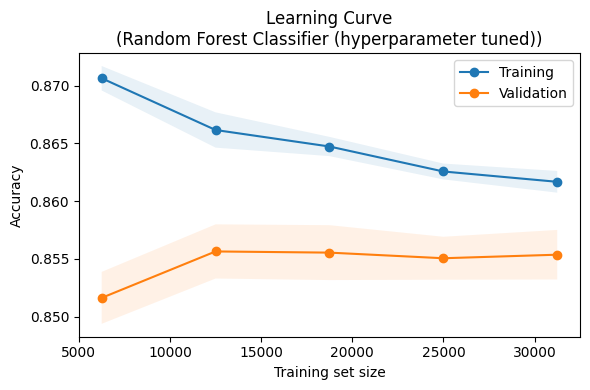


Random Forest Classifier (hyperparameter tuned) Report:
              precision    recall  f1-score   support

       <=50K     0.8712    0.9554    0.9114      7426
        >50K     0.7956    0.5511    0.6512      2337

    accuracy                         0.8587      9763
   macro avg     0.8334    0.7533    0.7813      9763
weighted avg     0.8531    0.8587    0.8491      9763

Accuracy: 0.8587

Random Forest Classifier (hyperparameter tuned) Confusion Matrix:


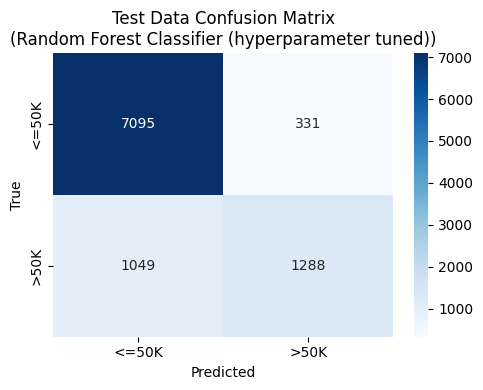

In [ ]:
# Build pipeline with the best RandomForestClassifier hyperparameters
rf_tuned_pipe = SkPipeline([
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', RandomForestClassifier(random_state=42))
]).set_params(**{k:int(v) if isinstance(v, np.float64) else v for k,v in rf_best_cv_params.items() if k != 'classifier'})

# Fit model
rf_tuned_pipe = fit_model(rf_tuned_pipe, X_train, y_train, 'rf_tuned_pipe.pkl')

# Create classification output
rf_tuned_accuracy = create_classification_output(rf_tuned_pipe, 'Random Forest Classifier (hyperparameter tuned)')

> After hyperparameter tuning, the random forest classifier achieved an accuracy of 85.9%, showing improved balance between training and validation accuracy. The model performed very well for ≤50K incomes (95.6% recall) but continued to struggle with >50K predictions (54.9% recall), suggesting that while tuning improved generalization, class imbalance remains a limiting factor.

### ROC Curves - Base vs. Hyperparameter Tuned Models

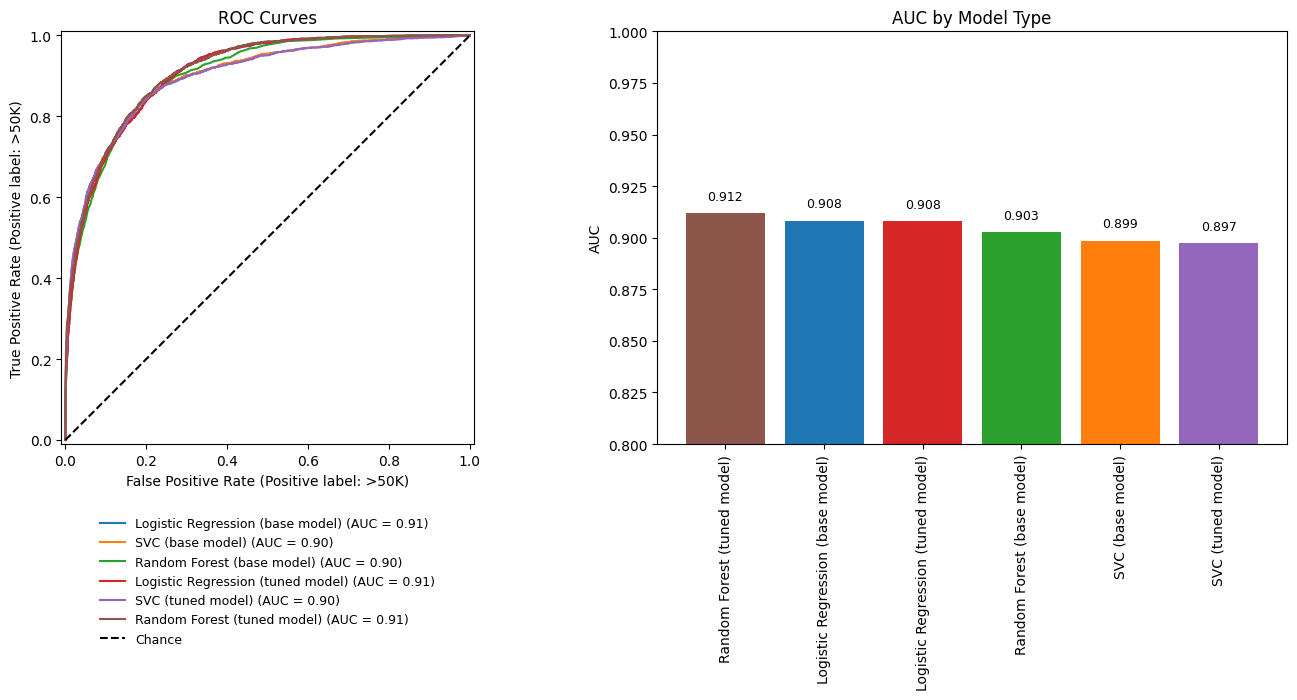

In [26]:
base_and_tuned_models = {
    'Logistic Regression (base model)':     logistic_pipe,
    'SVC (base model)':                     svc_pipe,
    'Random Forest (base model)':           rf_pipe,
    'Logistic Regression (tuned model)':    logistic_tuned_pipe,
    'SVC (tuned model)':                    svc_tuned_pipe,
    'Random Forest (tuned model)':          rf_tuned_pipe,
}

make_roc_curves(X_test, y_test, base_and_tuned_models)

> The ROC AUC results show that hyperparameter optimization produced only minor performance improvements, with all models achieving similar AUC scores between 0.89 and 0.91. The Random Forest (tuned) model performed best overall (AUC = 0.911), closely followed by both Logistic Regression versions (AUC = 0.908–0.91), indicating that tuning helped refine the models but did not significantly alter their relative performance.

### Hyperparameter Tuning - Conclusions/Discussions/Next Steps:
The hyperparameter tuning results showed that optimization slightly improved model stability and generalization, with all models achieving similar AUC scores between 0.89 and 0.91. The Random Forest model performed best overall after tuning, though all classifiers continued to struggle with accurately predicting >50K incomes due to class imbalance.  

The next step, Ensemble Modeling, will combine multiple tuned classifiers using voting and stacking techniques to leverage their individual strengths and improve overall predictive performance.

# Ensemble Methods
Ensemble methods like `VotingClassifier` and `StackingClassifier` combine multiple machine learning models to improve overall predictive performance. The `VotingClassifier` aggregates predictions from several base models and makes a final decision based on majority vote (for classification) or average (for regression). The `StackingClassifier`, on the other hand, uses the outputs of multiple base models as inputs to a “meta-model,” which learns how to best combine their predictions for improved accuracy and generalization.

### Voting Classifier
- This code creates and trains a soft voting ensemble that combines the tuned logistic regression, SVC, and random forest models, averaging their predicted probabilities to produce a final, more robust classification.

Loading saved model from voter.pkl

Voting Classifier Learning Curve:


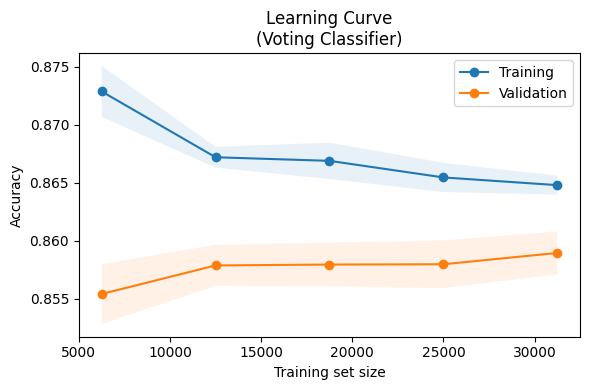


Voting Classifier Report:
              precision    recall  f1-score   support

       <=50K     0.8804    0.9500    0.9139      7426
        >50K     0.7880    0.5901    0.6748      2337

    accuracy                         0.8639      9763
   macro avg     0.8342    0.7701    0.7944      9763
weighted avg     0.8583    0.8639    0.8567      9763

Accuracy: 0.8639

Voting Classifier Confusion Matrix:


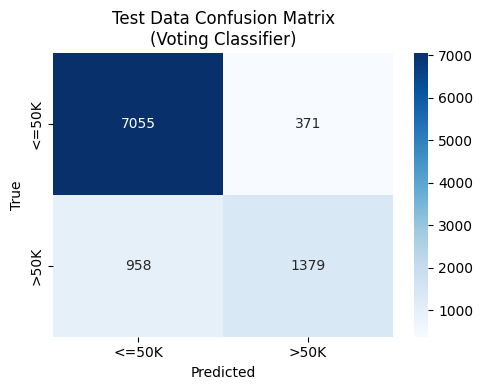

In [41]:
# Create a VotingClassifier ensemble instance
voter = VotingClassifier(
    estimators=[
        ('lr', logistic_tuned_pipe),
        ('svc', svc_tuned_pipe),
        ('rf',  rf_tuned_pipe)
    ],
    voting='soft',
    n_jobs=-1
)

# Fit the VotingClassifier ensemble model
voter = fit_model(voter, X_train, y_train, 'voter.pkl')

# Create classification output
voter_accuracy = create_classification_output(voter, 'Voting Classifier')

> The soft voting classifier achieved an overall accuracy of 86.4%, performing well on ≤50K incomes (95.0% recall) while maintaining balanced generalization across models. Although it did not significantly outperform the individual tuned models, it demonstrated strong stability and consistent predictive performance across both income classes.

### Stacking Classifier
- This code builds and trains a stacking ensemble that combines predictions from the tuned logistic regression, SVC, and random forest models, using a logistic regression meta-model to learn the best way to blend their outputs for improved overall accuracy.

Fitting model and saving to stacker.pkl

Stacking Classifier Learning Curve:


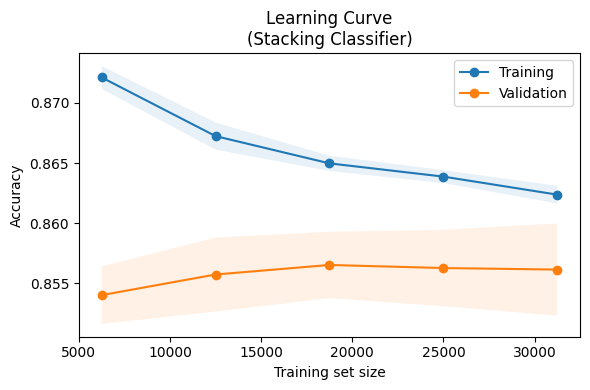


Stacking Classifier Report:
              precision    recall  f1-score   support

       <=50K     0.8795    0.9463    0.9117      7426
        >50K     0.7750    0.5879    0.6686      2337

    accuracy                         0.8605      9763
   macro avg     0.8272    0.7671    0.7901      9763
weighted avg     0.8545    0.8605    0.8535      9763

Accuracy: 0.8605

Stacking Classifier Confusion Matrix:


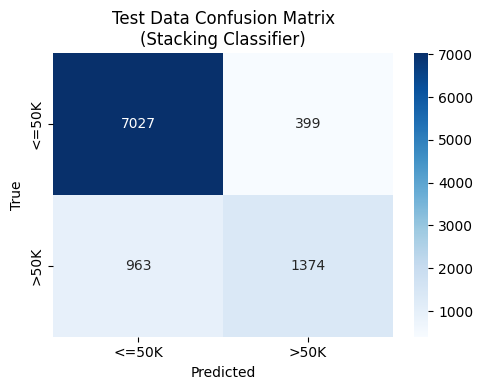

In [29]:
# Create a StackingClassifier ensemble instance
stacker = StackingClassifier(
    estimators=[
        ('lr',  logistic_tuned_pipe),
        ('svc', svc_tuned_pipe),
        ('rf',  rf_tuned_pipe)
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    passthrough=False,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# Fit the StackingClassifier ensemble model
stacker = fit_model(stacker, X_train, y_train, 'stacker.pkl')

# Create classification output
stacker_accuracy = create_classification_output(stacker, 'Stacking Classifier')

> The stacking classifier achieved an overall accuracy of 86.1%, maintaining consistent performance and strong generalization across models. While it slightly underperformed compared to the voting ensemble, it still produced balanced results with high recall for ≤50K incomes (94.6%) and moderate performance for >50K predictions (58.8%), indicating stable but incremental improvement over individual models.

### ROC Curves - Base vs. Ensemble Models
- Here we are comparing the performance of the base models and ensemble models by plotting their ROC curves on the test data to visually evaluate which approach best distinguishes between the income classes.

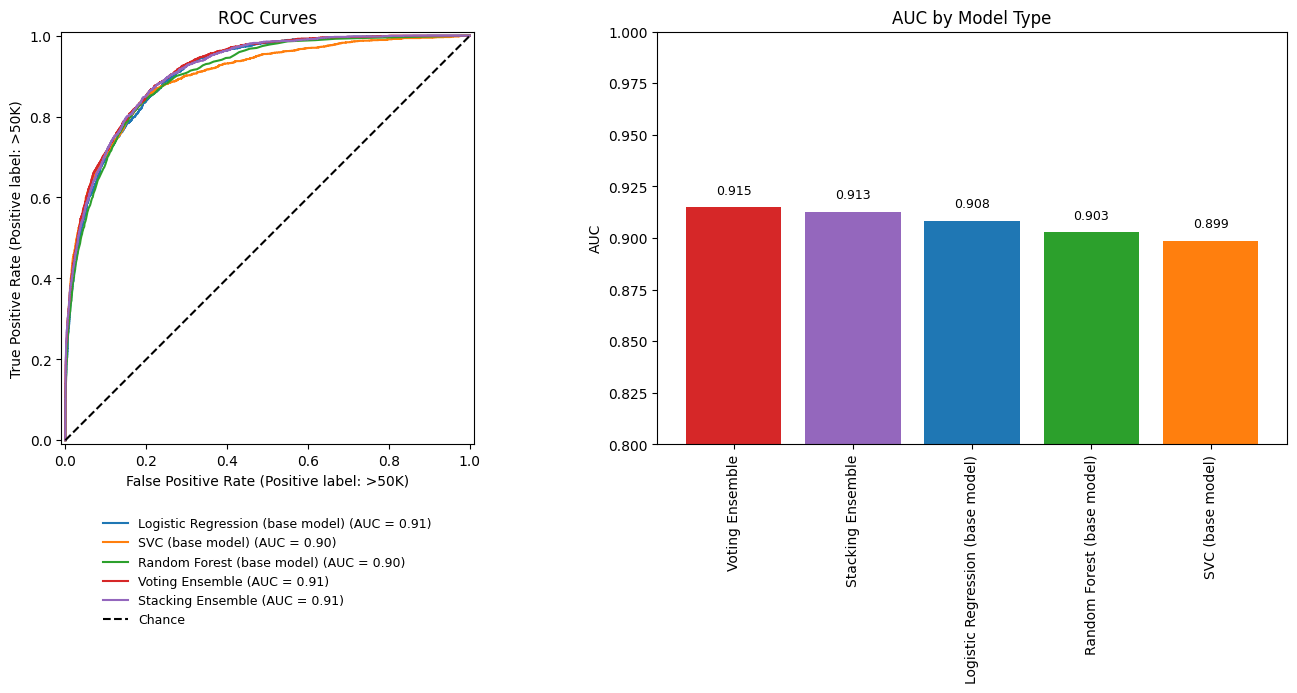

In [30]:
base_and_ensemble_models = {
    'Logistic Regression (base model)': logistic_pipe,
    'SVC (base model)':                 svc_pipe, 
    'Random Forest (base model)':       rf_pipe,
    'Voting Ensemble':                  voter,
    'Stacking Ensemble':                stacker, 
}

make_roc_curves(X_test, y_test, base_and_ensemble_models)

> The ROC AUC results show that both ensemble models outperformed the base classifiers, with the Voting Ensemble achieving the highest AUC of 0.915 and the Stacking Ensemble close behind at 0.913. These results indicate that combining the tuned models slightly improved overall classification performance and generalization compared to using individual models alone.

### Ensemble Methods - Conclusions/Discussions/Next Steps:
The ensemble modeling results showed that combining the tuned classifiers improved overall predictive performance, with the Voting Ensemble achieving the highest AUC (0.915) and the Stacking Ensemble performing similarly at 0.913. Both methods demonstrated stronger generalization than the individual base models, though improvements were incremental, suggesting diminishing returns from further model complexity.  

The next and final step, Results and Analysis, will summarize the overall model comparisons, highlight key performance insights, and discuss conclusions and potential recommendations based on the results.

# Results and Analysis

### ROC Curves - All Models
- Finally, we compare the performance of the base models, feature selection models, hyperparameter tuned model, and ensemble models by plotting their ROC curves on the test data to visually evaluate which approach best distinguishes between the income classes.

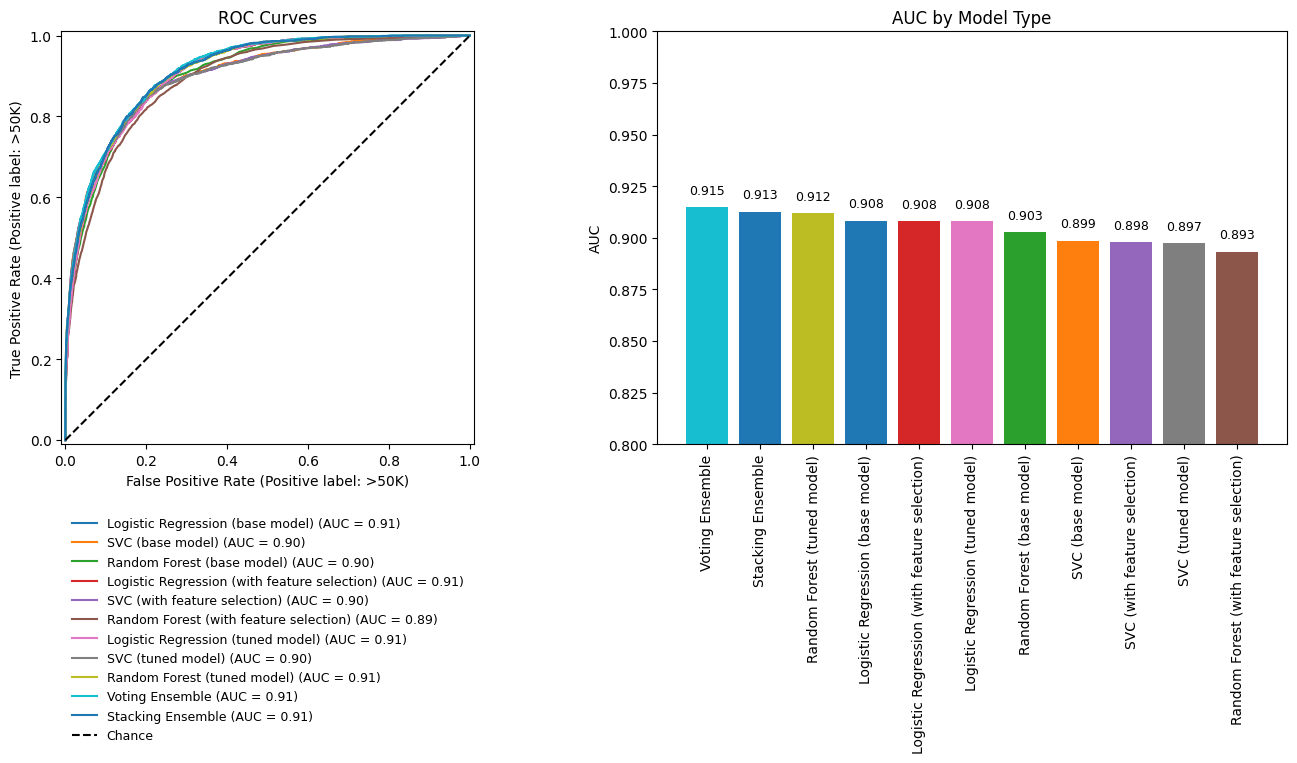

In [ ]:
all_models = {
    'Logistic Regression (base model)':             logistic_pipe,
    'SVC (base model)':                             svc_pipe, 
    'Random Forest (base model)':                   rf_pipe,
    'Logistic Regression (with feature selection)': logistic_fs_pipe,
    'SVC (with feature selection)':                 svc_fs_pipe,
    'Random Forest (with feature selection)':       rf_fs_pipe,
    'Logistic Regression (tuned model)':            logistic_tuned_pipe,
    'SVC (tuned model)':                            svc_tuned_pipe,
    'Random Forest (tuned model)':                  rf_tuned_pipe,
    'Voting Ensemble':                              voter,
    'Stacking Ensemble':                            stacker,
}

make_roc_curves(X_test, y_test, all_models)

> The ROC AUC charts show that all models performed consistently well, with AUC values ranging narrowly between 0.89 and 0.92, indicating strong discriminative ability across the board. The Voting Ensemble achieved the highest AUC (0.915), closely followed by the Stacking Ensemble and Random Forest (tuned) models, demonstrating that combining models provided a slight improvement in predictive power and generalization compared to individual classifiers.

### Model Accuracies
- By plotting the model accuracies, we can visually compare how each model and configuration performed relative to one another. This helps identify which modeling approach—base, feature-selected, tuned, or ensemble—achieved the highest accuracy and whether the additional complexity in later stages provided meaningful performance improvements.

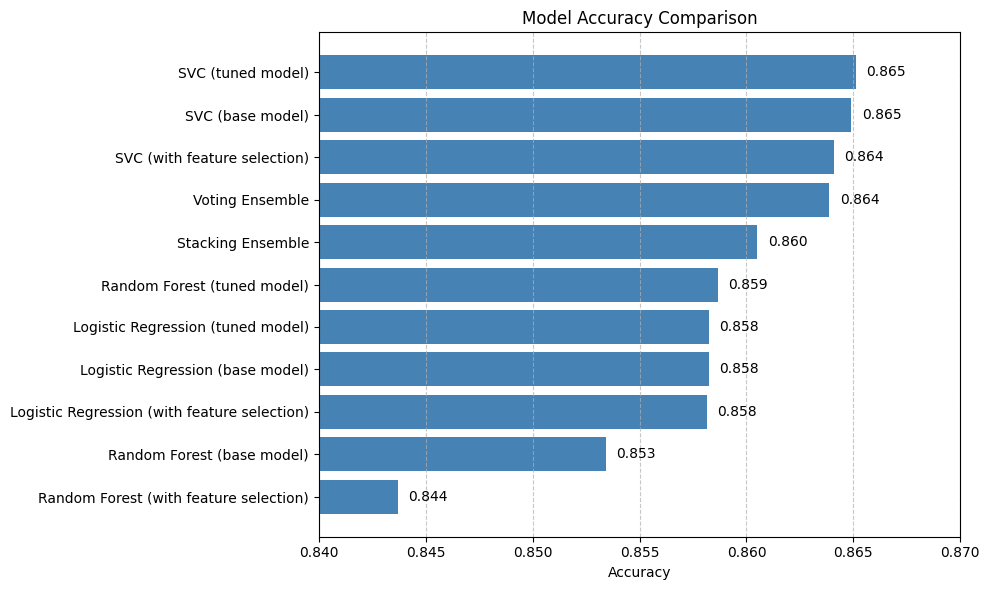

In [ ]:
# Create a dictionary of all the model accuracies
all_models_accuracy = {
    'Logistic Regression (base model)':             logistic_accuracy,
    'SVC (base model)':                             svc_accuracy, 
    'Random Forest (base model)':                   rf_accuracy,
    'Logistic Regression (with feature selection)': logistic_fs_accuracy,
    'SVC (with feature selection)':                 svc_fs_accuracy,
    'Random Forest (with feature selection)':       rf_fs_accuracy,
    'Logistic Regression (tuned model)':            logistic_tuned_accuracy,
    'SVC (tuned model)':                            svc_tuned_accuracy,
    'Random Forest (tuned model)':                  rf_tuned_accuracy,
    'Voting Ensemble':                              voter_accuracy,
    'Stacking Ensemble':                            stacker_accuracy,
}

# Convert to DataFrame and sort by accuracy
df = pd.DataFrame(list(all_models_accuracy.items()), columns=['Model', 'Accuracy'])
df = df.sort_values(by='Accuracy', ascending=True)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.barh(df['Model'], df['Accuracy'], color='steelblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.84, 0.87)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars with accuracy values
for i, v in enumerate(df['Accuracy']):
    plt.text(v + 0.0005, i, f"{v:.3f}", va='center')

plt.show()

> The model accuracy comparison shows that all models performed within a narrow range, with accuracies between 0.84 and 0.87. The SVC (tuned and base models) achieved the highest accuracy (0.865), followed closely by the Voting Ensemble and SVC with feature selection (0.864). Meanwhile, the Random Forest (with feature selection) performed the weakest at 0.844, suggesting that while feature selection sometimes simplified models effectively, it did not always lead to higher accuracy.

### Conclusions/Discussions/Next Steps:
The final model comparison results show that all classifiers performed consistently well, with SVC models achieving the highest accuracy and AUC scores, while ensemble methods such as Voting and Stacking provided slight but meaningful performance improvements. Feature selection did not always enhance results and, in some cases—particularly with the Random Forest—reduced accuracy, highlighting the trade-off between model simplicity and predictive strength.

# Discussion & Conclusion

### Learning and Takeaways  
Throughout this project, I learned how structured, iterative model development—beginning with data exploration and cleaning, followed by preprocessing, feature selection, hyperparameter tuning, and ensemble learning—can progressively refine predictive performance. Each stage of the analysis demonstrated how thoughtful handling of data quality, encoding, and scaling directly impacts model accuracy and generalization. Overall, the Support Vector Classifier (SVC) consistently delivered the strongest results, while ensemble approaches like Voting and Stacking further enhanced robustness and interpretability, illustrating the value of combining models to capture complex relationships in the data.

### Why Something Didn’t Work  
Not all modeling techniques produced performance gains as expected. In particular, feature selection reduced model complexity but occasionally removed informative variables—especially for Random Forest and SVC—leading to slight drops in accuracy and AUC. This occurred because these models naturally manage feature redundancy or capture non-linear relationships that are disrupted when certain predictors are removed. Additionally, class imbalance in the dataset (fewer >50K samples) caused models to consistently perform better for the ≤50K class, limiting recall for high-income predictions.

### Suggestions for Improvement
Future improvements could focus on refining feature engineering and imputation methods to preserve relationships among variables. Using IterativeImputer instead of SimpleImputer could generate more realistic imputations and prevent artificial correlations between categorical features like workclass and occupation. Encoding education as categorical rather than ordinal, or experimenting with target encoding, might also capture nuanced effects lost in numeric form. Finally, applying class balancing techniques such as SMOTE or class-weight adjustments, along with more diverse ensemble or gradient boosting methods (e.g., XGBoost or LightGBM), could further enhance performance, particularly for underrepresented income classes.